# Neural Network Framework

### Dependencies

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from utils import plot_decision_boundary

%matplotlib inline
    
%load_ext autoreload
%autoreload 2

### Definitions

In [2]:
class Sigmoid(object):
  def forward(self, Z):
    A = 1 / (1 + np.exp(-Z))
    cache = Z
    
    return A, cache
  
  def backward(self, dX, cache):
    Z = cache
    del cache
    
    s = 1 / (1 + np.exp(-Z))
    dZ = s * (1 - s)
    
    assert (dZ.shape == Z.shape)
    
    return dX * dZ

class Relu(object):
  def forward(self, Z):
    A = np.maximum(0,Z)
    
    assert(A.shape == Z.shape)
    
    cache = Z 
    return A, cache
 
  def backward(self, dX, cache):
    Z = cache
    del cache
    dZ = np.ones(Z.shape) # just converting dz to a correct object.
    
    # When z <= 0, you should set dz to 0 as well. 
    dZ[Z <= 0] = 0
    
    assert (dZ.shape == Z.shape)
    
    return dX * dZ

In [3]:
class LogisticLoss(object):
  def forward(self, A, Y):
    cache = {'A': A, 'Y': Y}
    value = -np.mean(Y * np.log(A) + (1 - Y) * np.log(1 - A))
    
    return value, cache
  
  def backward(self, dL, cache):
    A, Y = cache['A'], cache['Y']
    del cache
    
    return dL * -(Y / A) + (1 - Y) / (1 - A)

In [4]:
class Model(object):
  def __init__(self, layers, loss):
    self.layers = layers
    self.loss = loss
    
  def predict(self, X):
    A = X
    cache = {}
    
    for layer in self.layers:
      A, layer_cache = layer.forward(A)
      cache[layer] = layer_cache
      
    return A, cache 
    
  def forward(self, X, Y):
    cache = {}
    A, cache['predict'] = self.predict(X)
    loss, cache['loss'] = self.loss.forward(A, Y)
    return loss, cache
    
  def backward(self, dA, cache):
    predict, loss = cache['predict'], cache['loss']
    del cache
    dA = self.loss.backward(dA, loss)
    grads = {}
    
    for layer in reversed(self.layers):
      dA, layer_grads = layer.backward(dA, predict[layer])
      grads[layer] = layer_grads
      
    return grads
  
  def update(self, grads, learning_rate):
    for layer in self.layers:
      layer.update(grads[layer], learning_rate)

class Dense(object):
  def __init__(self, input_dim, output_dim, activation):
    self.W = np.random.randn(output_dim, input_dim) * 0.01
    self.b = np.zeros([output_dim, 1])
    self.activation = activation
    
  def forward(self, X):
    Z = np.dot(self.W, X) + self.b
    A, activation_cache = self.activation.forward(Z)
    cache = {'X': X, 'W': self.W, 'b': self.b, 'activation': activation_cache}
    return A, cache
  
  def backward(self, dA, cache):
    X, W, b, activation = cache['X'], cache['W'], cache['b'], cache['activation']
    del cache
    m = X.shape[1]
    
    dZ = self.activation.backward(dA, activation)
    dW = np.dot(dZ, X.T) / m
    db = np.sum(dZ, axis=1, keepdims=True) / m
    dX = np.dot(W.T, dZ)
    
    grads = {
      'dW': dW,
      'db': db
    }
    
    return dX, grads
  
  def update(self, grads, learning_rate):
    self.W -= learning_rate * grads['dW']
    self.b -= learning_rate * grads['db']

### Dataset

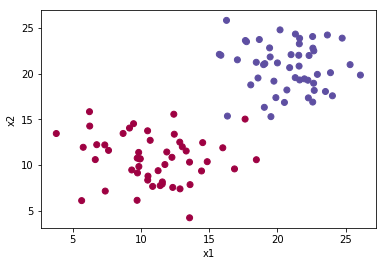

In [5]:
m = 100
X = np.ones([2, m]) + 10
X[:, m // 2:] += 10
X += np.random.randn(X.shape[0], X.shape[1]) * 3
Y = np.hstack([np.zeros((1, m // 2)), np.ones((1, m // 2))])

plt.scatter(X[0, :], X[1, :], c=Y, cmap=plt.cm.Spectral)
plt.ylabel('x2')
plt.xlabel('x1')

### Define and train model

step: 0, loss: 0.693146462518, accuracy: 56.0%
step: 500, loss: 0.693134391681, accuracy: 52.0%
step: 1000, loss: 0.69309381844, accuracy: 61.0%
step: 1500, loss: 0.692858387335, accuracy: 51.0%
step: 2000, loss: 0.680564120917, accuracy: 50.0%
step: 2500, loss: 0.562531649526, accuracy: 53.0%
step: 3000, loss: 0.462910921411, accuracy: 85.0%
step: 3500, loss: 0.355386604652, accuracy: 97.0%
step: 4000, loss: 0.24474970629, accuracy: 99.0%
step: 4500, loss: 0.159664634124, accuracy: 99.0%
step: 5000, loss: 0.115507379606, accuracy: 99.0%
step: 5500, loss: 0.0898050822589, accuracy: 99.0%
step: 6000, loss: 0.0729868646608, accuracy: 99.0%
step: 6500, loss: 0.0615494357127, accuracy: 99.0%
step: 7000, loss: 0.0525269291306, accuracy: 99.0%
step: 7500, loss: 0.0458035663272, accuracy: 99.0%
step: 8000, loss: 0.0411043248926, accuracy: 99.0%
step: 8500, loss: 0.036839844006, accuracy: 99.0%
step: 9000, loss: 0.0560375383472, accuracy: 99.0%
step: 9500, loss: 0.049267694491, accuracy: 99.0%

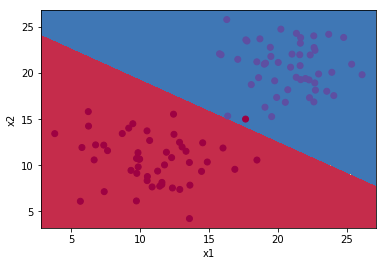

In [6]:
layers = [
  Dense(input_dim=2, output_dim=10, activation=Relu()),
  Dense(input_dim=10, output_dim=5, activation=Relu()),
  Dense(input_dim=5, output_dim=1, activation=Sigmoid())
]

model = Model(layers, loss=LogisticLoss())

steps = 10000
log_interval = 500
learning_rate = 0.01

for i in range(steps):
  loss, cache = model.forward(X, Y)
  grads = model.backward(1, cache)
  model.update(grads, learning_rate)
  
  if i % log_interval == 0:
    A, cache = model.predict(X)
    Y_hat = A > 0.5
    accuracy = np.mean(Y == Y_hat) * 100
    print('step: %s, loss: %s, accuracy: %s%%' % (i, loss, accuracy))
    
plot_decision_boundary(lambda x: model.predict(x.T)[0] > 0.5, X, Y, cmap=plt.cm.Spectral)
plt.ylabel('x2')
plt.xlabel('x1')